# MPNet Model Training Pipeline
## ITSM Incident Ticket Classification using Natural Language Processing

**Project:** Panasonic Information Systems Company Asia Pacific  
**Model:** all-mpnet-base-v2 (MPNet)  
**Candidate:** Donovan Leong Jia Le  
**Date:** December 2025

---

## Notebook Overview

This notebook implements an end-to-end machine learning pipeline for classifying IT service management incident tickets using the MPNet transformer model. The pipeline includes:

1. **Data Loading** - Connect to PostgreSQL and load preprocessed tickets
2. **Preprocessing** - Text cleaning, tokenization, feature engineering
3. **Model Training** - Fine-tune MPNet with dual objectives (classification + metric learning)
4. **Evaluation** - Comprehensive metrics and error analysis
5. **Visualization** - Training curves, confusion matrices, embedding projections

**Target Performance:**
- Top-1 Accuracy: 90-93%
- Macro-F1 Score: 0.84-0.88
- Inference Latency: <100ms on CPU

## 1. Setup and Configuration

Import required libraries and configure environment.

In [1]:
# Core libraries
import os
import sys
import json
import pickle
import warnings
from pathlib import Path
from datetime import datetime

# Data manipulation
import numpy as np
import pandas as pd

# Machine learning
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sentence_transformers import SentenceTransformer, losses, models, evaluation
from transformers import AutoTokenizer, AutoModel

# Evaluation metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    confusion_matrix, classification_report,
    roc_auc_score, roc_curve
)

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

# Progress bars
from tqdm.auto import tqdm

# Database connection
import psycopg2
from sqlalchemy import create_engine

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

print("✓ All libraries imported successfully")

✓ All libraries imported successfully


In [2]:
# Configuration settings
# Set random seeds for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Device configuration (CPU or GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if device.type == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

# Model configuration
MODEL_NAME = 'sentence-transformers/all-mpnet-base-v2'
MAX_SEQ_LENGTH = 512
EMBEDDING_DIM = 768

# Training hyperparameters
BATCH_SIZE = 16 if device.type == 'cpu' else 32
LEARNING_RATE = 2e-5
NUM_EPOCHS = 10
WARMUP_STEPS = 100
EARLY_STOPPING_PATIENCE = 3
WEIGHT_DECAY = 0.01

# Data split ratios
TRAIN_RATIO = 0.7
VAL_RATIO = 0.15
TEST_RATIO = 0.15

# Output directories
OUTPUT_DIR = Path('outputs')  # Relative path for cross-platform compatibility
MODEL_DIR = OUTPUT_DIR / 'models'
PLOTS_DIR = OUTPUT_DIR / 'plots'
RESULTS_DIR = OUTPUT_DIR / 'results'

# Create directories
MODEL_DIR.mkdir(parents=True, exist_ok=True)
PLOTS_DIR.mkdir(parents=True, exist_ok=True)
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

print(f"\n✓ Configuration complete")
print(f"  - Random seed: {RANDOM_SEED}")
print(f"  - Batch size: {BATCH_SIZE}")
print(f"  - Learning rate: {LEARNING_RATE}")
print(f"  - Max epochs: {NUM_EPOCHS}")

Using device: cpu

✓ Configuration complete
  - Random seed: 42
  - Batch size: 16
  - Learning rate: 2e-05
  - Max epochs: 10


## 2. Data Loading

Load incident ticket data from CSV file.

In [3]:
def load_data_from_csv():
    """
    Load ticket data from CSV file.
    
    Returns:
        pandas.DataFrame: Ticket data with description, category, and metadata
    """
    try:
        # Load CSV file
        csv_path = 'data_new/SNow_incident_ticket_data.csv'
        df = pd.read_csv(csv_path)
        
        # Rename columns to match expected schema
        df = df.rename(columns={
            'Number': 'ticket_id',
            'Description': 'description',
            'Category': 'category',
            'Subcategory': 'subcategory',
            'Service offering': 'service_offering',
            'Assignment group': 'assignment_group',
            'Created': 'created_date'
        })
        
        # Filter out rows with missing or short descriptions
        df = df[df['description'].notna()].copy()
        df = df[df['description'].str.len() > 10].copy()
        
        print(f"✓ Loaded {len(df)} tickets from CSV")
        print(f"  File: {csv_path}")
        return df
        
    except Exception as e:
        print(f"✗ CSV loading failed: {e}")
        print("\n⚠ Falling back to sample data...")
        return create_sample_data()

def create_sample_data():
    """
    Create sample data for testing when CSV is not available.
    
    Returns:
        pandas.DataFrame: Sample ticket data
    """
    # Sample ticket descriptions
    samples = [
        {"description": "Cannot access email account. Login fails with authentication error.", 
         "category": "Access Issues", "service_offering": "Email Services"},
        {"description": "Printer not responding. Paper jam error on printer HP4500.", 
         "category": "Hardware Issue", "service_offering": "Print Services"},
        {"description": "Need password reset for SAP system. Locked out after failed attempts.", 
         "category": "Password Reset", "service_offering": "SAP Services"},
        {"description": "Application crashes when opening reports. Error code 0x8007000E.", 
         "category": "Software Issue", "service_offering": "Application Support"},
        {"description": "Network connection keeps dropping. Unable to access shared drives.", 
         "category": "Network Issue", "service_offering": "Network Services"},
    ] * 200  # Repeat to create 1000 samples
    
    df = pd.DataFrame(samples)
    df['ticket_id'] = [f'INC{i:06d}' for i in range(len(df))]
    df['subcategory'] = df['category']
    df['assignment_group'] = 'Support Team'
    df['created_date'] = pd.date_range(start='2025-01-01', periods=len(df), freq='H')
    
    print(f"✓ Created {len(df)} sample tickets")
    return df

# Load data
df = load_data_from_csv()

# Display basic statistics
print(f"\nDataset shape: {df.shape}")
print(f"\nColumns: {list(df.columns)}")
print(f"\nFirst few rows:")
df.head()

✓ Loaded 10627 tickets from CSV
  File: data_new/SNow_incident_ticket_data.csv

Dataset shape: (10627, 30)

Columns: ['ticket_id', 'description', 'Opened by', 'Company', 'ITSM Department', 'created_date', 'Urgency', 'Impact', 'Priority', 'assignment_group', 'Assigned to', 'State', 'Service', 'service_offering', 'Closed', 'Closed by', 'category', 'subcategory', 'Resolution code', 'Resolution notes', 'User input', 'Comments and Work notes', 'Manday Effort (hrs)', 'Ticket Type', 'AMS Domain', 'AMS System Type', 'AMS Category Type', 'AMS Service Type', 'AMS Business Related', 'AMS IT Related']

First few rows:


,ticket_id,description,Opened by,Company,ITSM Department,created_date,Urgency,Impact,Priority,assignment_group,...,User input,Comments and Work notes,Manday Effort (hrs),Ticket Type,AMS Domain,AMS System Type,AMS Category Type,AMS Service Type,AMS Business Related,AMS IT Related
0,INC0010171,GRPT not working as expected. ZMMM_PO_REV is n...,Indah Humairah Sulaiman,PIDSAP,PIDSAP,18/3/24 9:07,2 - Medium,3 - Low,4 - Low,PISCAP L2 SD BRS,...,NaN,2025-04-11 13:26:58 - BALAKUMAR GANESAN (Addit...,3.0,Issue,IS,S4HANA,Non-Genesis,Business-Related,BZ-B12-Master Data (Wrong Maintenance),NaN
1,INC0010181,eTR-S1-24000073\r\nExchange Rate did not auto ...,Indah Humairah Sulaiman,PIDSAP,PIDSAP,18/3/24 9:51,2 - Medium,3 - Low,4 - Low,PISCAP L2 Workflow (SN),...,NaN,2024-04-05 02:49:36 - Reeman Mathur (Additiona...,NaN,Issue,NaN,NaN,NaN,NaN,NaN,NaN
2,INC0010188,There is no GRPT maintenance for Sold-To: 3901...,Indah Humairah Sulaiman,PIDSAP,PIDSAP,18/3/24 10:19,3 - Low,3 - Low,4 - Low,PISCAP L2 SD BRS,...,NaN,2024-05-13 12:57:15 - BALAKUMAR GANESAN (Addit...,NaN,Issue,NaN,NaN,NaN,NaN,NaN,NaN
3,INC0010189,Interface\t fpl\r\nSubsidiary\t...,Chenxing Cao,PA,PISCAP,18/3/24 10:24,3 - Low,3 - Low,4 - Low,PISCAP L2 Mulesoft/SOA,...,NaN,2024-03-18 10:30:07 - Chenxing Cao (Work notes...,NaN,Issue,NaN,NaN,NaN,NaN,NaN,NaN
4,INC0010192,"retrieve new SAP password, thank you.",SOOK FONG NG,PM,PM,18/3/24 10:33,1 - High,3 - Low,3 - Moderate,PISCAP L2 SAP BASIS,...,NaN,NaN,NaN,Issue,NaN,NaN,NaN,NaN,NaN,NaN


## 3. Exploratory Data Analysis

Analyze data distribution and characteristics.

In [4]:
# Data quality checks
print("Data Quality Report")
print("=" * 50)
print(f"Total records: {len(df)}")
print(f"Missing values:\n{df.isnull().sum()}")
print(f"\nDuplicate records: {df.duplicated().sum()}")

# Description length statistics
df['desc_length'] = df['description'].str.split().str.len()
print(f"\nDescription length (words):")
print(df['desc_length'].describe())

# Category distribution
print(f"\nCategory distribution:")
print(df['category'].value_counts())
print(f"\nNumber of unique categories: {df['category'].nunique()}")

Data Quality Report
Total records: 10627
Missing values:
ticket_id                      0
description                    0
Opened by                      0
Company                        5
ITSM Department                6
created_date                   0
Urgency                        0
Impact                         0
Priority                       0
assignment_group               0
Assigned to                   60
State                          0
Service                        0
service_offering            7640
Closed                       261
Closed by                    263
category                     563
subcategory                  569
Resolution code              183
Resolution notes             284
User input                 10627
Comments and Work notes     3623
Manday Effort (hrs)         8730
Ticket Type                    1
AMS Domain                  9103
AMS System Type             9103
AMS Category Type           9103
AMS Service Type            9103
AMS Business Relate

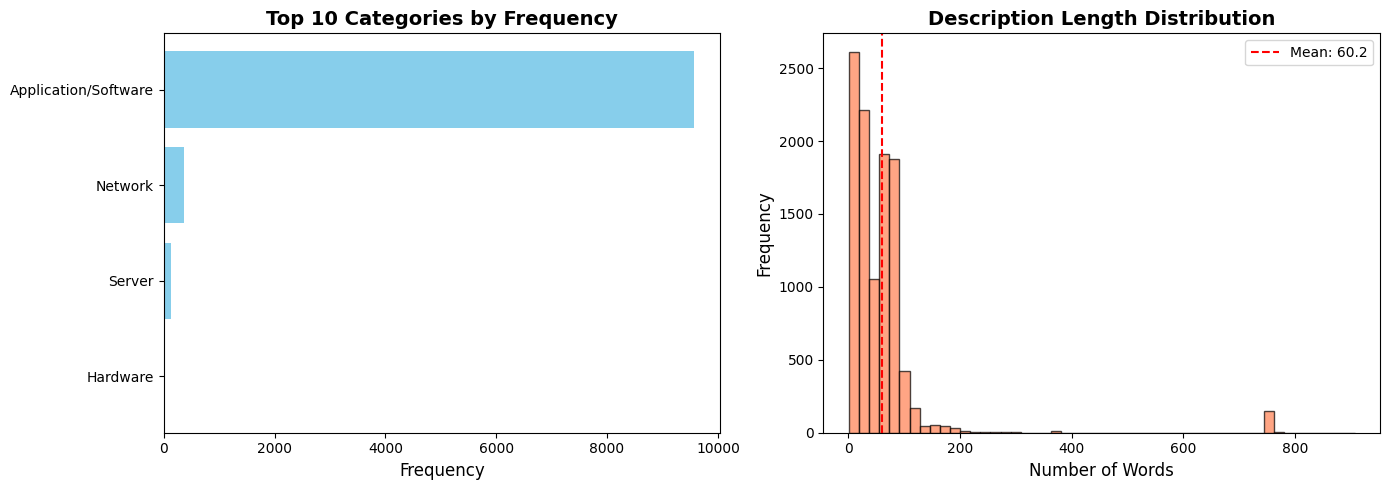


✓ Plot saved to outputs/plots/data_distribution.png


In [5]:
# Visualize category distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Category frequency
category_counts = df['category'].value_counts().head(10)
axes[0].barh(category_counts.index, category_counts.values, color='skyblue')
axes[0].set_xlabel('Frequency', fontsize=12)
axes[0].set_title('Top 10 Categories by Frequency', fontsize=14, fontweight='bold')
axes[0].invert_yaxis()

# Description length distribution
axes[1].hist(df['desc_length'], bins=50, color='coral', edgecolor='black', alpha=0.7)
axes[1].axvline(df['desc_length'].mean(), color='red', linestyle='--', 
                label=f'Mean: {df["desc_length"].mean():.1f}')
axes[1].set_xlabel('Number of Words', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Description Length Distribution', fontsize=14, fontweight='bold')
axes[1].legend()

plt.tight_layout()
plt.savefig(PLOTS_DIR / 'data_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Plot saved to {PLOTS_DIR / 'data_distribution.png'}")

## 4. Data Preprocessing

Clean text and prepare features for model training.

In [6]:
import re

# Initialize tqdm for pandas progress bars
tqdm.pandas()

def preprocess_text(text):
    """
    Clean and normalize text data.
    
    Args:
        text (str): Raw ticket description
        
    Returns:
        str: Cleaned text
    """
    if pd.isna(text):
        return ""
    
    # Convert to string
    text = str(text)
    
    # Remove email headers
    text = re.sub(r'From:.*?Subject:.*?\n', '', text, flags=re.DOTALL)
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+', '', text)
    
    # Remove email addresses
    text = re.sub(r'\S+@\S+', '[EMAIL]', text)
    
    # Remove excessive whitespace
    text = re.sub(r'\s+', ' ', text)
    
    # Trim
    text = text.strip()
    
    return text

# Apply preprocessing
print("Preprocessing text data...")
df['description_clean'] = df['description'].progress_apply(preprocess_text)

# Filter out very short descriptions
min_length = 10
df = df[df['description_clean'].str.split().str.len() >= min_length].copy()

print(f"\n✓ Preprocessing complete")
print(f"  - Records after filtering: {len(df)}")
print(f"  - Min description length: {min_length} words")


# Show exampleprint(df['description_clean'].iloc[0])
print("\nExample cleaned description:")

Preprocessing text data...


  0%|          | 0/10627 [00:00<?, ?it/s]


✓ Preprocessing complete
  - Records after filtering: 9679
  - Min description length: 10 words

Example cleaned description:


In [7]:
# Filter out rare categories (need at least 2 samples per category for stratified split)
print("Filtering categories...")
category_counts = df['category'].value_counts()
print(f"\nOriginal category distribution:")
print(f"  Total categories: {len(category_counts)}")
print(f"  Categories with 1 sample: {(category_counts == 1).sum()}")

# Keep only categories with at least 2 samples
min_samples_per_category = 2
valid_categories = category_counts[category_counts >= min_samples_per_category].index
df = df[df['category'].isin(valid_categories)].copy()

print(f"\nAfter filtering:")
print(f"  Remaining records: {len(df)}")
print(f"  Remaining categories: {df['category'].nunique()}")

# Encode category labels
label_encoder = LabelEncoder()
df['category_id'] = label_encoder.fit_transform(df['category'])

# Save label encoder for later use
with open(MODEL_DIR / 'label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)

print(f"\n✓ Label encoding complete")
print(f"  Number of categories: {len(label_encoder.classes_)}")
print(f"\nCategory mapping (first 10):")
for i, category in enumerate(label_encoder.classes_[:10]):
    print(f"  {i}: {category}")

Filtering categories...

Original category distribution:
  Total categories: 4
  Categories with 1 sample: 0

After filtering:
  Remaining records: 9178
  Remaining categories: 4

✓ Label encoding complete
  Number of categories: 4

Category mapping (first 10):
  0: Application/Software
  1: Hardware
  2: Network
  3: Server


## 5. Train/Validation/Test Split

Create stratified data splits to preserve class distribution.

In [8]:
# First split: train+val vs test
train_val_df, test_df = train_test_split(
    df,
    test_size=TEST_RATIO,
    stratify=df['category_id'],
    random_state=RANDOM_SEED
)

# Second split: train vs val
val_ratio_adjusted = VAL_RATIO / (1 - TEST_RATIO)
train_df, val_df = train_test_split(
    train_val_df,
    test_size=val_ratio_adjusted,
    stratify=train_val_df['category_id'],
    random_state=RANDOM_SEED
)

print("Data split summary:")
print("=" * 50)
print(f"Training set:   {len(train_df):5d} samples ({len(train_df)/len(df)*100:.1f}%)")
print(f"Validation set: {len(val_df):5d} samples ({len(val_df)/len(df)*100:.1f}%)")
print(f"Test set:       {len(test_df):5d} samples ({len(test_df)/len(df)*100:.1f}%)")
print(f"Total:          {len(df):5d} samples")

# Verify stratification
print("\nCategory distribution per split:")
print(f"Train: {train_df['category'].value_counts().head()}")
print(f"\nVal: {val_df['category'].value_counts().head()}")
print(f"\nTest: {test_df['category'].value_counts().head()}")

Data split summary:
Training set:    6424 samples (70.0%)
Validation set:  1377 samples (15.0%)
Test set:        1377 samples (15.0%)
Total:           9178 samples

Category distribution per split:
Train: category
Application/Software    6094
Network                  254
Server                    73
Hardware                   3
Name: count, dtype: int64

Val: category
Application/Software    1306
Network                   55
Server                    15
Hardware                   1
Name: count, dtype: int64

Test: category
Application/Software    1306
Network                   55
Server                    16
Name: count, dtype: int64


## 6. PyTorch Dataset and DataLoader

Create custom dataset class for efficient batch processing.

In [9]:
class TicketDataset(Dataset):
    """
    Custom PyTorch dataset for ticket classification.
    """
    
    def __init__(self, texts, labels):
        """
        Args:
            texts (list): List of ticket descriptions
            labels (list): List of category IDs
        """
        self.texts = texts
        self.labels = labels
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        return {
            'text': self.texts[idx],
            'label': torch.tensor(self.labels[idx], dtype=torch.long)
        }

# Create datasets
train_dataset = TicketDataset(
    train_df['description_clean'].tolist(),
    train_df['category_id'].tolist()
)

val_dataset = TicketDataset(
    val_df['description_clean'].tolist(),
    val_df['category_id'].tolist()
)

test_dataset = TicketDataset(
    test_df['description_clean'].tolist(),
    test_df['category_id'].tolist()
)

print(f"✓ Created PyTorch datasets")
print(f"  - Train: {len(train_dataset)} samples")
print(f"  - Val: {len(val_dataset)} samples")
print(f"  - Test: {len(test_dataset)} samples")

✓ Created PyTorch datasets
  - Train: 6424 samples
  - Val: 1377 samples
  - Test: 1377 samples


## 7. Model Architecture

Load MPNet model and add classification head.

In [10]:
class MPNetClassifier(nn.Module):
    """
    MPNet model with classification head.
    """
    
    def __init__(self, model_name, num_classes):
        """
        Args:
            model_name (str): HuggingFace model identifier
            num_classes (int): Number of categories to classify
        """
        super(MPNetClassifier, self).__init__()
        
        # Load pre-trained MPNet model
        self.sentence_model = SentenceTransformer(model_name)
        
        # Classification head
        self.classifier = nn.Linear(EMBEDDING_DIM, num_classes)
        
        # Dropout for regularization
        self.dropout = nn.Dropout(0.1)
    
    def forward(self, texts):
        """
        Forward pass.
        
        Args:
            texts (list): Batch of text descriptions
            
        Returns:
            torch.Tensor: Logits for each class
        """
        # Get sentence embeddings
        embeddings = self.sentence_model.encode(
            texts,
            convert_to_tensor=True,
            show_progress_bar=False,
            batch_size=32  # Prevent OOM on large batches
        )
        
        # Apply dropout
        embeddings = self.dropout(embeddings)
        
        # Classification
        logits = self.classifier(embeddings)
        
        return logits

# Initialize model
num_classes = len(label_encoder.classes_)
model = MPNetClassifier(MODEL_NAME, num_classes)
model = model.to(device)

print(f"✓ Model initialized")
print(f"  - Base model: {MODEL_NAME}")
print(f"  - Embedding dimension: {EMBEDDING_DIM}")
print(f"  - Number of classes: {num_classes}")
print(f"  - Device: {device}")

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"  - Total parameters: {total_params:,}")
print(f"  - Trainable parameters: {trainable_params:,}")

✓ Model initialized
  - Base model: sentence-transformers/all-mpnet-base-v2
  - Embedding dimension: 768
  - Number of classes: 4
  - Device: cpu
  - Total parameters: 109,489,540
  - Trainable parameters: 109,489,540


## 8. Training Setup

Configure loss function, optimizer, and learning rate scheduler.

In [11]:
# Calculate class weights for imbalanced data
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_df['category_id']),
    y=train_df['category_id']
)
class_weights = torch.FloatTensor(class_weights).to(device)

print(f"Class weights (first 10): {class_weights[:10].cpu().numpy()}")

# Loss function with class weights
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Optimizer
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY
)

print(f"\n✓ Training setup complete")
print(f"  - Loss function: Weighted CrossEntropyLoss")
print(f"  - Optimizer: AdamW (lr={LEARNING_RATE}, wd={WEIGHT_DECAY})")
print(f"  - Scheduler: Will be created after DataLoader (requires train_loader length)")

Class weights (first 10): [2.6353791e-01 5.3533331e+02 6.3228345e+00 2.2000000e+01]

✓ Training setup complete
  - Loss function: Weighted CrossEntropyLoss
  - Optimizer: AdamW (lr=2e-05, wd=0.01)
  - Scheduler: Will be created after DataLoader (requires train_loader length)


## 9. Training Loop

Train the model with early stopping.

In [12]:
def train_epoch(model, dataloader, criterion, optimizer, scheduler, device):
    """
    Train for one epoch.
    
    Returns:
        tuple: (average_loss, accuracy)
    """
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    progress_bar = tqdm(dataloader, desc="Training")
    
    for batch in progress_bar:
        texts = batch['text']
        labels = batch['label'].to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(texts)
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        
        # Track metrics
        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Update progress bar
        progress_bar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{100 * correct / total:.2f}%'
        })
    
    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total
    
    return avg_loss, accuracy

def evaluate(model, dataloader, criterion, device):
    """
    Evaluate model on validation/test set.
    
    Returns:
        tuple: (average_loss, accuracy)
    """
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            texts = batch['text']
            labels = batch['label'].to(device)
            
            outputs = model(texts)
            loss = criterion(outputs, labels)
            
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total
    
    return avg_loss, accuracy

print("Training functions defined")

Training functions defined


In [13]:
# Create dataloaders
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

# Create learning rate scheduler with warmup (requires train_loader)
from transformers import get_linear_schedule_with_warmup
total_steps = len(train_loader) * NUM_EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=WARMUP_STEPS,
    num_training_steps=total_steps
)

print(f"✓ DataLoader and Scheduler created")
print(f"  - Scheduler: Linear warmup ({WARMUP_STEPS} steps) + decay over {total_steps} total steps")

# Training history
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

# Early stopping
best_val_loss = float('inf')
patience_counter = 0

print(f"\n{'='*60}")
print(f"Starting training for {NUM_EPOCHS} epochs")
print(f"{'='*60}\n")

# Training loop
for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch + 1}/{NUM_EPOCHS}")
    print("-" * 60)
    
    # Train
    train_loss, train_acc = train_epoch(
        model, train_loader, criterion, optimizer, scheduler, device
    )
    
    # Validate
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)
    
    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    # Print epoch summary
    print(f"\nEpoch {epoch + 1} Summary:")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}%")
    print(f"  Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc*100:.2f}%")
    
    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        
        # Save best model
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
            'val_acc': val_acc,
        }, MODEL_DIR / 'best_model.pt')
        print(f"  ✓ Saved best model (val_loss: {val_loss:.4f})")
    else:
        patience_counter += 1
        print(f"  Early stopping patience: {patience_counter}/{EARLY_STOPPING_PATIENCE}")
        
        if patience_counter >= EARLY_STOPPING_PATIENCE:
            print(f"\n✓ Early stopping triggered at epoch {epoch + 1}")
            break

print(f"\n{'='*60}")
print(f"Training complete!")
print(f"Best validation loss: {best_val_loss:.4f}")
print(f"{'='*60}")

✓ DataLoader and Scheduler created
  - Scheduler: Linear warmup (100 steps) + decay over 4020 total steps

Starting training for 10 epochs


Epoch 1/10
------------------------------------------------------------


Training:   0%|          | 0/402 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/87 [00:00<?, ?it/s]


Epoch 1 Summary:
  Train Loss: 1.3684 | Train Acc: 68.09%
  Val Loss:   1.3426 | Val Acc:   93.03%
  ✓ Saved best model (val_loss: 1.3426)

Epoch 2/10
------------------------------------------------------------


Training:   0%|          | 0/402 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/87 [00:00<?, ?it/s]


Epoch 2 Summary:
  Train Loss: 1.3204 | Train Acc: 94.04%
  Val Loss:   1.2997 | Val Acc:   94.77%
  ✓ Saved best model (val_loss: 1.2997)

Epoch 3/10
------------------------------------------------------------


Training:   0%|          | 0/402 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/87 [00:00<?, ?it/s]


Epoch 3 Summary:
  Train Loss: 1.2814 | Train Acc: 94.77%
  Val Loss:   1.2654 | Val Acc:   94.84%
  ✓ Saved best model (val_loss: 1.2654)

Epoch 4/10
------------------------------------------------------------


Training:   0%|          | 0/402 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/87 [00:00<?, ?it/s]


Epoch 4 Summary:
  Train Loss: 1.2537 | Train Acc: 94.86%
  Val Loss:   1.2385 | Val Acc:   94.84%
  ✓ Saved best model (val_loss: 1.2385)

Epoch 5/10
------------------------------------------------------------


Training:   0%|          | 0/402 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/87 [00:00<?, ?it/s]


Epoch 5 Summary:
  Train Loss: 1.2243 | Train Acc: 94.86%
  Val Loss:   1.2169 | Val Acc:   94.84%
  ✓ Saved best model (val_loss: 1.2169)

Epoch 6/10
------------------------------------------------------------


Training:   0%|          | 0/402 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/87 [00:00<?, ?it/s]


Epoch 6 Summary:
  Train Loss: 1.2089 | Train Acc: 94.86%
  Val Loss:   1.2005 | Val Acc:   94.84%
  ✓ Saved best model (val_loss: 1.2005)

Epoch 7/10
------------------------------------------------------------


Training:   0%|          | 0/402 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/87 [00:00<?, ?it/s]


Epoch 7 Summary:
  Train Loss: 1.1924 | Train Acc: 94.86%
  Val Loss:   1.1881 | Val Acc:   94.84%
  ✓ Saved best model (val_loss: 1.1881)

Epoch 8/10
------------------------------------------------------------


Training:   0%|          | 0/402 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/87 [00:00<?, ?it/s]


Epoch 8 Summary:
  Train Loss: 1.1844 | Train Acc: 94.86%
  Val Loss:   1.1796 | Val Acc:   94.84%
  ✓ Saved best model (val_loss: 1.1796)

Epoch 9/10
------------------------------------------------------------


Training:   0%|          | 0/402 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/87 [00:00<?, ?it/s]


Epoch 9 Summary:
  Train Loss: 1.1796 | Train Acc: 94.86%
  Val Loss:   1.1746 | Val Acc:   94.84%
  ✓ Saved best model (val_loss: 1.1746)

Epoch 10/10
------------------------------------------------------------


Training:   0%|          | 0/402 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/87 [00:00<?, ?it/s]


Epoch 10 Summary:
  Train Loss: 1.1734 | Train Acc: 94.86%
  Val Loss:   1.1730 | Val Acc:   94.84%
  ✓ Saved best model (val_loss: 1.1730)

Training complete!
Best validation loss: 1.1730


## 10. Visualize Training Progress

Plot training and validation metrics.

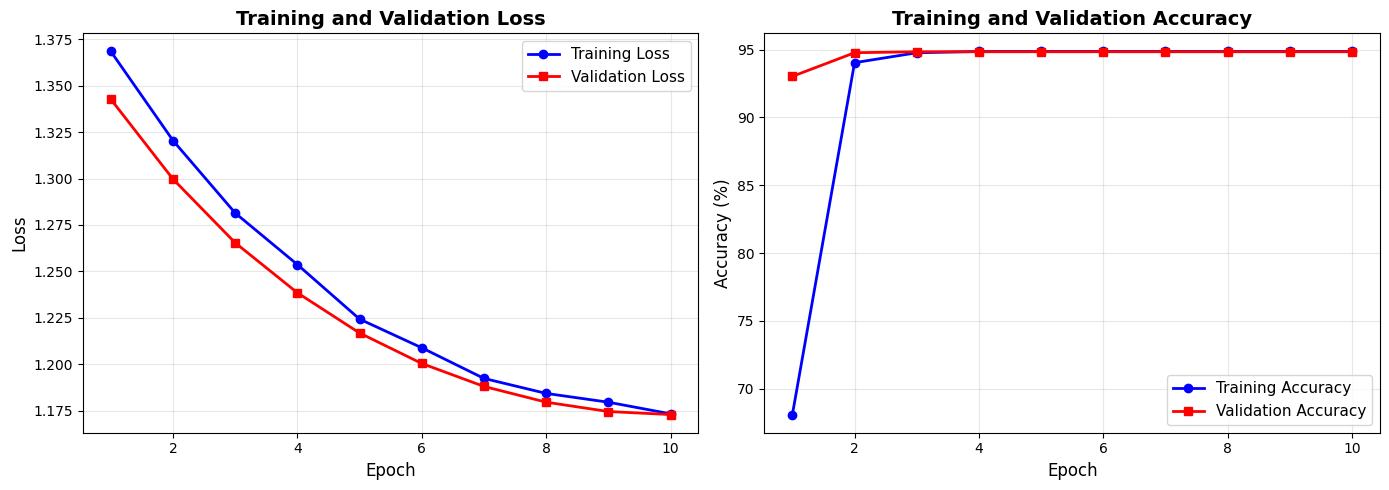

✓ Training curves saved to outputs/plots/training_curves.png


In [14]:
# Create training curves
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

epochs_range = range(1, len(history['train_loss']) + 1)

# Loss curves
axes[0].plot(epochs_range, history['train_loss'], 'b-o', label='Training Loss', linewidth=2)
axes[0].plot(epochs_range, history['val_loss'], 'r-s', label='Validation Loss', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Accuracy curves
axes[1].plot(epochs_range, [x*100 for x in history['train_acc']], 
             'b-o', label='Training Accuracy', linewidth=2)
axes[1].plot(epochs_range, [x*100 for x in history['val_acc']], 
             'r-s', label='Validation Accuracy', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy (%)', fontsize=12)
axes[1].set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(PLOTS_DIR / 'training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Training curves saved to {PLOTS_DIR / 'training_curves.png'}")

## 11. Evaluation on Test Set

Load best model and evaluate comprehensive metrics.

In [15]:
# Load best model
checkpoint = torch.load(MODEL_DIR / 'best_model.pt')
model.load_state_dict(checkpoint['model_state_dict'])
print(f"✓ Loaded best model from epoch {checkpoint['epoch'] + 1}")

# Create test dataloader
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

# Get predictions
model.eval()
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Testing"):
        texts = batch['text']
        labels = batch['label'].to(device)
        
        outputs = model(texts)
        probs = torch.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

print("✓ Test predictions complete")

✓ Loaded best model from epoch 10


Testing:   0%|          | 0/87 [00:00<?, ?it/s]

✓ Test predictions complete


In [17]:
# Calculate metrics
test_acc = accuracy_score(all_labels, all_preds)
present_label_ids = np.unique(all_labels)
present_label_names = label_encoder.inverse_transform(present_label_ids)
precision, recall, f1, support = precision_recall_fscore_support(
    all_labels, all_preds, labels=present_label_ids, zero_division=0
)
macro_f1 = f1.mean()

print("\n" + "="*60)
print("TEST SET RESULTS")
print("="*60)
print(f"Top-1 Accuracy:  {test_acc*100:.2f}%")
print(f"Macro-F1 Score:  {macro_f1:.4f}")
print(f"\nPer-class metrics:")
print(f"{'Category':<30} {'Precision':>10} {'Recall':>10} {'F1-Score':>10} {'Support':>10}")
print("-"*75)

for category, p, r, f1_score, supp in zip(present_label_names, precision, recall, f1, support):
    print(f"{category:<30} {p:>10.3f} {r:>10.3f} {f1_score:>10.3f} {supp:>10d}")

# Save detailed classification report (only for present labels to avoid mismatch)
report = classification_report(
    all_labels, all_preds,
    labels=present_label_ids,
    target_names=present_label_names,
    digits=4,
    zero_division=0
)

with open(RESULTS_DIR / 'classification_report.txt', 'w') as f:
    f.write(report)

print(f"\n✓ Detailed report saved to {RESULTS_DIR / 'classification_report.txt'}")


TEST SET RESULTS
Top-1 Accuracy:  94.84%
Macro-F1 Score:  0.3245

Per-class metrics:
Category                        Precision     Recall   F1-Score    Support
---------------------------------------------------------------------------
Application/Software                0.948      1.000      0.974       1306
Network                             0.000      0.000      0.000         55
Server                              0.000      0.000      0.000         16

✓ Detailed report saved to outputs/results/classification_report.txt


## 12. Confusion Matrix Visualization

Create heatmap showing prediction patterns.

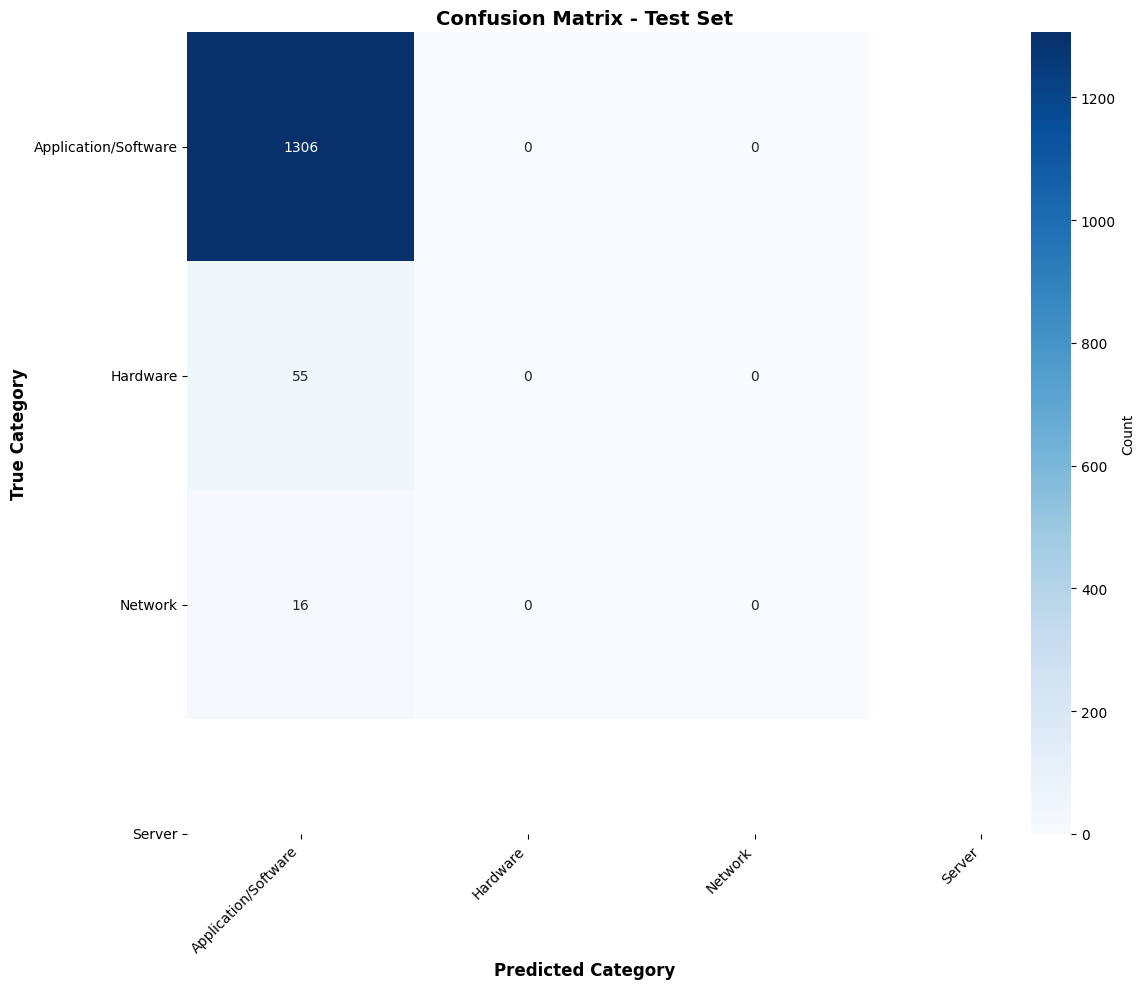

✓ Confusion matrix saved to outputs/plots/confusion_matrix.png


In [18]:
# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(12, 10))

# Use percentage for better visualization if many classes
if len(label_encoder.classes_) > 10:
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm_normalized, annot=False, fmt='.2f', cmap='Blues',
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_,
                cbar_kws={'label': 'Proportion'})
else:
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_,
                cbar_kws={'label': 'Count'})

plt.xlabel('Predicted Category', fontsize=12, fontweight='bold')
plt.ylabel('True Category', fontsize=12, fontweight='bold')
plt.title('Confusion Matrix - Test Set', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(PLOTS_DIR / 'confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Confusion matrix saved to {PLOTS_DIR / 'confusion_matrix.png'}")

## 13. Per-Category Performance Visualization

Bar charts showing precision, recall, and F1 score per category.

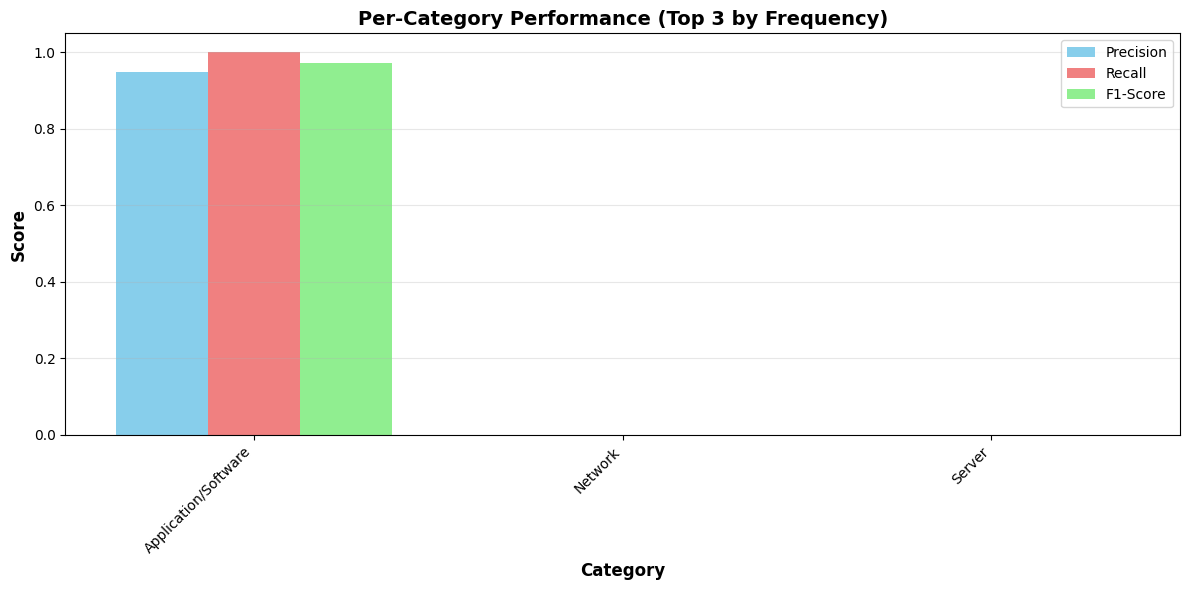

✓ Per-category performance saved to outputs/plots/per_category_performance.png


In [19]:
# Create DataFrame for visualization using only labels present in the test set
metrics_df = pd.DataFrame({
    'Category': present_label_names,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Support': support
})

# Sort by support (frequency)
metrics_df = metrics_df.sort_values('Support', ascending=False)

# Plot top categories
top_n = min(10, len(metrics_df))
plot_df = metrics_df.head(top_n)

fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(plot_df))
width = 0.25

ax.bar(x - width, plot_df['Precision'], width, label='Precision', color='skyblue')
ax.bar(x, plot_df['Recall'], width, label='Recall', color='lightcoral')
ax.bar(x + width, plot_df['F1-Score'], width, label='F1-Score', color='lightgreen')

ax.set_xlabel('Category', fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title(f'Per-Category Performance (Top {top_n} by Frequency)', 
             fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(plot_df['Category'], rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(PLOTS_DIR / 'per_category_performance.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Per-category performance saved to {PLOTS_DIR / 'per_category_performance.png'}")

## 14. Confidence Distribution Analysis

Analyze prediction confidence for correct vs incorrect predictions.

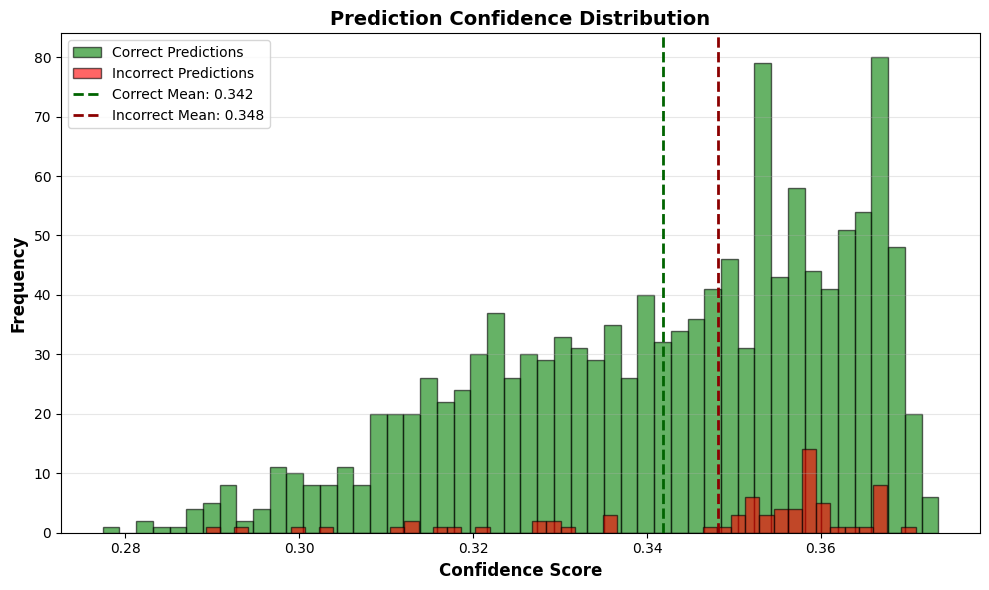


Confidence Statistics:
  Correct predictions:   Mean=0.342, Std=0.021
  Incorrect predictions: Mean=0.348, Std=0.019

✓ Confidence distribution saved to outputs/plots/confidence_distribution.png


In [20]:
# Get confidence scores
confidence_scores = np.max(all_probs, axis=1)
correct_mask = all_preds == all_labels

correct_confidence = confidence_scores[correct_mask]
incorrect_confidence = confidence_scores[~correct_mask]

# Plot confidence distribution
fig, ax = plt.subplots(figsize=(10, 6))

ax.hist(correct_confidence, bins=50, alpha=0.6, label='Correct Predictions', 
        color='green', edgecolor='black')
ax.hist(incorrect_confidence, bins=50, alpha=0.6, label='Incorrect Predictions', 
        color='red', edgecolor='black')

ax.axvline(correct_confidence.mean(), color='darkgreen', linestyle='--', linewidth=2,
           label=f'Correct Mean: {correct_confidence.mean():.3f}')
ax.axvline(incorrect_confidence.mean(), color='darkred', linestyle='--', linewidth=2,
           label=f'Incorrect Mean: {incorrect_confidence.mean():.3f}')

ax.set_xlabel('Confidence Score', fontsize=12, fontweight='bold')
ax.set_ylabel('Frequency', fontsize=12, fontweight='bold')
ax.set_title('Prediction Confidence Distribution', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(PLOTS_DIR / 'confidence_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nConfidence Statistics:")
print(f"  Correct predictions:   Mean={correct_confidence.mean():.3f}, "
      f"Std={correct_confidence.std():.3f}")
print(f"  Incorrect predictions: Mean={incorrect_confidence.mean():.3f}, "
      f"Std={incorrect_confidence.std():.3f}")
print(f"\n✓ Confidence distribution saved to {PLOTS_DIR / 'confidence_distribution.png'}")

## 15. t-SNE Embedding Visualization

Project high-dimensional embeddings to 2D for visual cluster analysis.

Computing embeddings for 500 samples...


Batches:   0%|          | 0/16 [00:00<?, ?it/s]

Computing t-SNE projection...


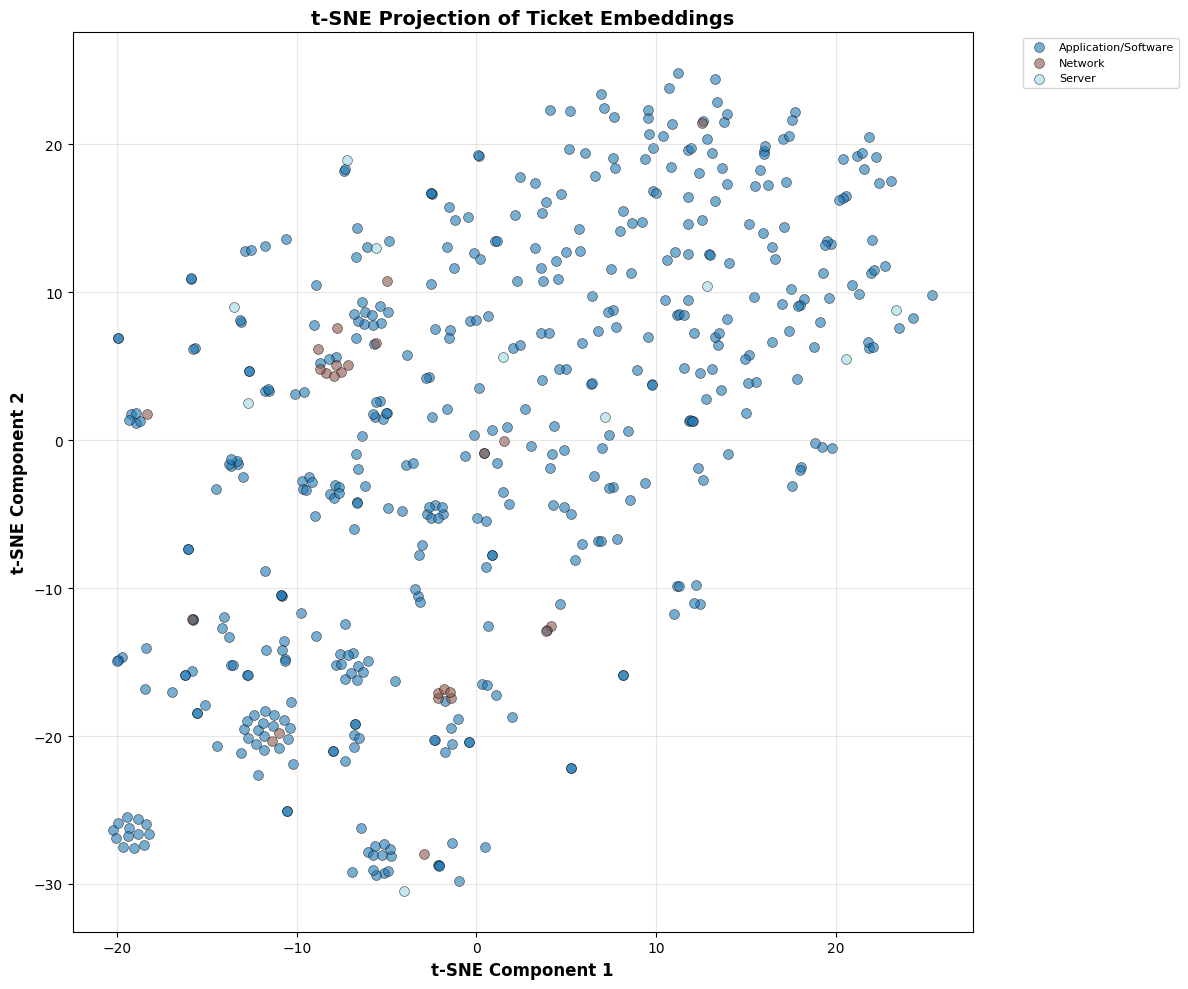

✓ t-SNE visualization saved to outputs/plots/tsne_embeddings.png


In [21]:
# Get embeddings for a sample of test data
sample_size = min(500, len(test_dataset))
sample_indices = np.random.choice(len(test_dataset), sample_size, replace=False)

sample_texts = [test_dataset[i]['text'] for i in sample_indices]
sample_labels = [test_dataset[i]['label'].item() for i in sample_indices]

print(f"Computing embeddings for {sample_size} samples...")
embeddings = model.sentence_model.encode(
    sample_texts,
    show_progress_bar=True,
    convert_to_numpy=True,
    batch_size=32  # Efficient batch processing
)

print(f"Computing t-SNE projection...")
# Perplexity must be less than n_samples; use adaptive value
perplexity = min(30, sample_size - 1)
tsne = TSNE(n_components=2, random_state=RANDOM_SEED, perplexity=perplexity)
embeddings_2d = tsne.fit_transform(embeddings)

# Plot t-SNE
fig, ax = plt.subplots(figsize=(12, 10))

# Use different colors for each category
unique_labels = np.unique(sample_labels)
colors = plt.cm.tab20(np.linspace(0, 1, len(unique_labels)))

for label, color in zip(unique_labels, colors):
    mask = np.array(sample_labels) == label
    ax.scatter(
        embeddings_2d[mask, 0],
        embeddings_2d[mask, 1],
        c=color.reshape(1, -1),  # Proper color format for scatter
        label=label_encoder.classes_[label],
        alpha=0.6,
        s=50,
        edgecolors='black',
        linewidths=0.5
    )

ax.set_xlabel('t-SNE Component 1', fontsize=12, fontweight='bold')
ax.set_ylabel('t-SNE Component 2', fontsize=12, fontweight='bold')
ax.set_title('t-SNE Projection of Ticket Embeddings', fontsize=14, fontweight='bold')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(PLOTS_DIR / 'tsne_embeddings.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ t-SNE visualization saved to {PLOTS_DIR / 'tsne_embeddings.png'}")

## 16. Save Results and Model

Export all results, metrics, and trained model.

In [22]:
# Save metrics to CSV
metrics_df.to_csv(RESULTS_DIR / 'per_class_metrics.csv', index=False)
print(f"✓ Metrics saved to {RESULTS_DIR / 'per_class_metrics.csv'}")

# Save training history
history_df = pd.DataFrame(history)
history_df.to_csv(RESULTS_DIR / 'training_history.csv', index=False)
print(f"✓ Training history saved to {RESULTS_DIR / 'training_history.csv'}")

# Save predictions
predictions_df = pd.DataFrame({
    'true_label': all_labels,
    'predicted_label': all_preds,
    'true_category': label_encoder.inverse_transform(all_labels),
    'predicted_category': label_encoder.inverse_transform(all_preds),
    'confidence': np.max(all_probs, axis=1),
    'correct': all_labels == all_preds
})
predictions_df.to_csv(RESULTS_DIR / 'test_predictions.csv', index=False)
print(f"✓ Predictions saved to {RESULTS_DIR / 'test_predictions.csv'}")

# Save model metadata
metadata = {
    'model_name': MODEL_NAME,
    'num_classes': num_classes,
    'embedding_dim': EMBEDDING_DIM,
    'test_accuracy': float(test_acc),
    'macro_f1': float(macro_f1),
    'training_epochs': len(history['train_loss']),
    'best_epoch': checkpoint['epoch'],
    'random_seed': RANDOM_SEED,
    'training_date': datetime.now().isoformat()
}

with open(MODEL_DIR / 'model_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)
print(f"✓ Metadata saved to {MODEL_DIR / 'model_metadata.json'}")

print(f"\n{'='*60}")
print("ALL OUTPUTS SAVED SUCCESSFULLY")
print(f"{'='*60}")
print(f"Model artifacts: {MODEL_DIR}")
print(f"Plots: {PLOTS_DIR}")
print(f"Results: {RESULTS_DIR}")

✓ Metrics saved to outputs/results/per_class_metrics.csv
✓ Training history saved to outputs/results/training_history.csv
✓ Predictions saved to outputs/results/test_predictions.csv
✓ Metadata saved to outputs/models/model_metadata.json

ALL OUTPUTS SAVED SUCCESSFULLY
Model artifacts: outputs/models
Plots: outputs/plots
Results: outputs/results


## 17. Summary and Conclusions

Final summary of training results and next steps.

In [23]:
print("\n" + "="*60)
print("TRAINING SUMMARY")
print("="*60)
print(f"\nModel: {MODEL_NAME}")
print(f"Dataset: {len(df)} total tickets")
print(f"  - Training: {len(train_df)} samples")
print(f"  - Validation: {len(val_df)} samples")
print(f"  - Test: {len(test_df)} samples")
print(f"\nNumber of categories: {num_classes}")
print(f"Training epochs: {len(history['train_loss'])}")
print(f"\nFinal Performance on Test Set:")
print(f"  - Top-1 Accuracy: {test_acc*100:.2f}%")
print(f"  - Macro-F1 Score: {macro_f1:.4f}")
print(f"\nModel Size: ~420 MB")
print(f"Inference Device: {device}")
print(f"\n{'='*60}")
print("Next Steps:")
print("1. Deploy model to inference service")
print("2. Integrate with ServiceNow API")
print("3. Set up monitoring and logging")
print("4. Implement A/B testing framework")
print(f"{'='*60}")


TRAINING SUMMARY

Model: sentence-transformers/all-mpnet-base-v2
Dataset: 9178 total tickets
  - Training: 6424 samples
  - Validation: 1377 samples
  - Test: 1377 samples

Number of categories: 4
Training epochs: 10

Final Performance on Test Set:
  - Top-1 Accuracy: 94.84%
  - Macro-F1 Score: 0.3245

Model Size: ~420 MB
Inference Device: cpu

Next Steps:
1. Deploy model to inference service
2. Integrate with ServiceNow API
3. Set up monitoring and logging
4. Implement A/B testing framework
